# 🛡️ PatchCore Otimizado para Raspberry Pi 5 (8GB)
Este notebook utiliza **Coreset Sampling** e **Sparse Random Projection** para manter a detecção de detalhes sutis sem sacrificar a performance no hardware de borda.

1. Instalação e Configuração (Obrigatório após reiniciar)
Primeiro, vamos instalar as bibliotecas. Corre isto assim que o notebook ligar.

In [1]:
# Instalação com versão corrigida e disponível
!pip install openvino==2024.1.0 timm scikit-learn torch torchvision

import torch
import torch.nn.functional as F
import numpy as np
import os
import shutil
import cv2
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# Bibliotecas de base (substituindo o anomalib)
from sklearn.random_projection import SparseRandomProjection
import timm

print(f"✅ Ambiente Pronto. GPU: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.7/38.7 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 113.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.36.3 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have

KeyboardInterrupt: 

2. Preparar os Dados (Descompactar e Carregar)
Substitui dataset.zip pelo nome exato do ficheiro que fizeste upload para o Colab.

In [2]:
import zipfile
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

print("📂 A PREPARAR DADOS...")

# 1. DESCOMPACTAR (Ajusta o nome do ficheiro se necessário)
zip_path = "/content/batch_20260126_102943.zip"  # <--- CONFIRMA SE O NOME ESTÁ CORRETO
extract_path = "dataset"

if os.path.exists(zip_path):
    print(f"   -> A descompactar {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("   -> Descompactação concluída.")
else:
    print(f"⚠️ AVISO: Não encontrei '{zip_path}'. Assume-se que a pasta '{extract_path}' já existe ou vais fazer upload manual.")

# 2. CONFIGURAR DATALOADER
# Transformações padrão (ImageNet)
transform_train = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("   -> A carregar imagens para a memória...")
try:
    # Procura recursivamente por imagens dentro da pasta extraída
    # O ImageFolder exige estrutura: root/classe/imagem.png
    # Se o teu zip já tiver pastas (ex: train/good), aponta para a raiz

    # Tenta encontrar a pasta 'train' automaticamente
    train_dir = os.path.join(extract_path, "train")
    if not os.path.exists(train_dir):
        # Se não houver pasta 'train', tenta usar a raiz extraída
        train_dir = extract_path

    train_ds = ImageFolder(train_dir, transform=transform_train)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    print(f"✅ SUCESSO: Dataset carregado com {len(train_ds)} imagens.")

    # Verificar classes encontradas
    print(f"   -> Classes encontradas: {train_ds.classes}")

except Exception as e:
    print(f"❌ ERRO CRÍTICO: Não consegui carregar as imagens.")
    print(f"   Detalhe: {e}")
    print("   DICA: O ImageFolder precisa de subpastas. Ex: dataset/train/good/img1.png")

📂 A PREPARAR DADOS...
   -> A descompactar /content/batch_20260126_102943.zip...
   -> Descompactação concluída.
   -> A carregar imagens para a memória...
❌ ERRO CRÍTICO: Não consegui carregar as imagens.
   Detalhe: Couldn't find any class folder in dataset/train.
   DICA: O ImageFolder precisa de subpastas. Ex: dataset/train/good/img1.png


3. Preparar os Dados
Define onde estão as tuas imagens. Ajusta o caminho root se necessário.

In [3]:
import torch
import os
import shutil
import glob
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

print("🧹 A ARRUMAR A CASA E CARREGAR DADOS...")

# 1. DEFINIR O DESTINO PADRÃO
root_dir = "dataset"
target_dir = os.path.join(root_dir, "train", "good")

# Criar a pasta de destino se não existir
os.makedirs(target_dir, exist_ok=True)

# 2. ENCONTRAR TODAS AS IMAGENS (Onde quer que estejam)
# Procura recursivamente por png e jpg dentro de 'dataset'
pngs = glob.glob(os.path.join(root_dir, "**", "*.png"), recursive=True)
jpgs = glob.glob(os.path.join(root_dir, "**", "*.jpg"), recursive=True)
todas_imagens = pngs + jpgs

print(f"   -> Encontrei {len(todas_imagens)} imagens no total.")

# 3. MOVER TUDO PARA O SÍTIO CERTO
count = 0
for img_path in todas_imagens:
    # Se a imagem já estiver no sítio certo, ignora
    if target_dir in img_path:
        continue

    # Define o novo caminho
    nome_ficheiro = os.path.basename(img_path)
    novo_caminho = os.path.join(target_dir, nome_ficheiro)

    # Move
    try:
        shutil.move(img_path, novo_caminho)
        count += 1
    except Exception as e:
        print(f"⚠️ Erro ao mover {nome_ficheiro}: {e}")

if count > 0:
    print(f"   -> Movi {count} imagens dispersas para '{target_dir}'.")
else:
    print("   -> As imagens já estavam no sítio certo.")

# 4. LIMPEZA DE PASTAS VAZIAS (Opcional, para não confundir)
# Removemos a pasta 'dataset/good' se ela ficou vazia e está fora de 'train'
path_antigo_good = os.path.join(root_dir, "good")
if os.path.exists(path_antigo_good) and path_antigo_good != target_dir:
    try:
        # Só remove se estiver vazia
        os.rmdir(path_antigo_good)
        print("   -> Pasta antiga 'dataset/good' removida.")
    except:
        pass # Se não estiver vazia, deixa estar

# 5. CARREGAR O DATASET (Agora vai funcionar!)
transform_train = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

try:
    # Apontamos para dataset/train. O ImageFolder vai ver a pasta 'good' lá dentro.
    train_root = os.path.join(root_dir, "train")
    train_ds = ImageFolder(train_root, transform=transform_train)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

    print(f"✅ SUCESSO: Dataset carregado com {len(train_ds)} imagens.")
    print(f"   -> Estrutura final: {train_root}/good/*.png")
except Exception as e:
    print(f"❌ ERRO FINAL: {e}")
    # Debug: Listar o que ficou
    print("   Conteúdo de dataset/train:", os.listdir(train_root))

🧹 A ARRUMAR A CASA E CARREGAR DADOS...
   -> Encontrei 672 imagens no total.
   -> Movi 672 imagens dispersas para 'dataset/train/good'.
✅ SUCESSO: Dataset carregado com 672 imagens.
   -> Estrutura final: dataset/train/good/*.png


4. O CÉREBRO UNIFICADO (Treino e Calibração)
Esta é a célula mágica. Ela define o modelo, treina e calibra a tolerância tudo junto para evitar que as peças se desconectem.

Ela também corrige o erro de dimensão (784 vs 448) internamente.

In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import timm  # <--- O import que faltava
from sklearn.random_projection import SparseRandomProjection # Usamos o sklearn direto
from tqdm import tqdm

print("🧠 A INICIAR TREINO DO PATCHCORE (Lógica Unificada)...")

# 1. DEFINIÇÃO DA CLASSE DO MODELO
class PatchCoreEngine(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Backbone ResNet18 (Extrai características)
        # Usamos features_only=True para pegar nas camadas intermédias
        self.backbone = timm.create_model('resnet18', pretrained=True, features_only=True, out_indices=[1, 2])
        self.backbone.eval() # Congelar backbone

        # Projetor (Reduz dimensão e mistura features)
        self.projector = SparseRandomProjection(eps=0.9)

        # Memória (Será preenchida no treino)
        self.register_buffer("memory_bank", torch.zeros(1, 1))
        self.register_buffer("projection_matrix", torch.zeros(1, 1))

    def forward_features(self, x):
        # 1. Extrair Features
        features = self.backbone(x)

        # 2. Upscale e Concatenação
        # features[0] é layer 2, features[1] é layer 3
        f1 = features[0]
        f2 = features[1]

        f1 = F.interpolate(f1, size=f2.shape[-2:], mode='bilinear', align_corners=False)
        emb = torch.cat((f1, f2), 1) # Concatenar canais
        return emb

    def forward(self, x):
        # Inferência Completa (Usada na exportação)
        emb = self.forward_features(x)
        b, c, h, w = emb.shape

        # Flatten para projeção
        emb_flat = emb.permute(0, 2, 3, 1).reshape(-1, c)

        # Projetar
        proj = torch.matmul(emb_flat, self.projection_matrix)

        # Distância Euclideana (Feature -> Memória)
        dist = torch.cdist(proj, self.memory_bank)
        min_dist, _ = torch.min(dist, dim=1)

        # 3. RESHAPE & RESIZE (A Correção Crítica para o Pi)
        # O mapa volta a ser uma imagem (b, 1, h, w)
        feature_map = min_dist.view(b, 1, h, w)

        # Interpolamos para 448x448 para ter o mapa final suave
        heatmap = F.interpolate(feature_map, size=(448, 448), mode='bilinear', align_corners=False)

        return heatmap

# Instanciar e Mover para GPU
sistema = PatchCoreEngine().to(device)
print("✅ Sistema instanciado.")

# ---------------------------------------------------------
# 2. TREINO (PREENCHER BANCO DE MEMÓRIA)
# ---------------------------------------------------------
print("🔄 A extrair características das latas boas...")
embeddings = []
projector_fitted = False

with torch.no_grad():
    for images, _ in tqdm(train_loader):
        images = images.to(device)
        emb = sistema.forward_features(images)

        # Preparar para projetor
        b, c, h, w = emb.shape
        emb_flat = emb.permute(0, 2, 3, 1).reshape(-1, c)

        # Ajustar projetor (só na primeira vez)
        if not projector_fitted:
            # O sklearn corre em CPU
            sistema.projector.fit(emb_flat.cpu().numpy())

            # Guardar matriz de projeção no buffer do modelo
            raw_matrix = sistema.projector.sparse_random_matrix
            if hasattr(raw_matrix, "toarray"):
                m = torch.tensor(raw_matrix.toarray(), dtype=torch.float32)
            else:
                m = torch.tensor(raw_matrix, dtype=torch.float32)

            # Transpor para multiplicação correta (Input x Matriz)
            if m.shape[0] < m.shape[1]: m = m.t() # Garante forma (Features, Componentes)

            sistema.projection_matrix = m.to(device)
            projector_fitted = True

        # Projetar e guardar
        proj = torch.matmul(emb_flat, sistema.projection_matrix)
        embeddings.append(proj)

# Criar Coreset (Amostragem de 10% para não pesar no Pi)
full_embedding = torch.cat(embeddings, dim=0)
n_samples = int(full_embedding.shape[0] * 0.1) # 10%
indices = torch.randperm(full_embedding.shape[0])[:n_samples]
sistema.memory_bank = full_embedding[indices].contiguous()

print(f"✅ Memória Criada: {sistema.memory_bank.shape}")

# ---------------------------------------------------------
# 3. CALIBRAÇÃO (DEFINIR THRESHOLD)
# ---------------------------------------------------------
print("🛡️ A calcular Mapa de Tolerância (Zonas)...")
anomaly_maps = []

with torch.no_grad():
    for images, _ in tqdm(train_loader):
        images = images.to(device)
        # Usamos o forward completo que já faz o resize para 448x448!
        maps = sistema(images)
        anomaly_maps.append(maps.cpu().numpy())

# Calcular estatísticas pixel a pixel
stack = np.concatenate(anomaly_maps, axis=0).squeeze() # (N, 448, 448)
mean = np.mean(stack, axis=0)
std = np.std(stack, axis=0)
max_val = np.max(stack, axis=0)

# FÓRMULA DE SEGURANÇA
# Média + 4 Desvios Padrão, mas nunca abaixo do máximo visto no treino
threshold_map = np.maximum(mean + (4.0 * std), max_val * 1.05)
# Piso mínimo para evitar ruído em zonas pretas
threshold_map = np.maximum(threshold_map, 15.0)

print(f"✅ Calibração Concluída. Mapa Min: {threshold_map.min():.2f}, Max: {threshold_map.max():.2f}")
np.save("threshold_map_final.npy", threshold_map)

🧠 A INICIAR TREINO DO PATCHCORE (Lógica Unificada)...


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

NameError: name 'device' is not defined

In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import timm
from sklearn.random_projection import SparseRandomProjection
from tqdm import tqdm
import os
import gc

# Limpar memória GPU antes de começar
torch.cuda.empty_cache()
gc.collect()

print("🧠 A INICIAR TREINO (Versão Otimizada para Memória)...")

# 0. CONFIGURAÇÃO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if 'train_loader' not in globals():
    raise ValueError("❌ ERRO: O 'train_loader' não existe. Corre o PASSO 2 primeiro!")

# 1. DEFINIÇÃO DA CLASSE DO MODELO (COM CHUNKING)
class PatchCoreEngine(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Backbone ResNet18
        self.backbone = timm.create_model('resnet18', pretrained=True, features_only=True, out_indices=[1, 2])
        self.backbone.eval()

        # Projetor (128 dimensões)
        self.projector = SparseRandomProjection(n_components=128)

        # Buffers
        self.register_buffer("memory_bank", torch.zeros(1, 1))
        self.register_buffer("projection_matrix", torch.zeros(1, 1))

    def forward_features(self, x):
        features = self.backbone(x)
        f1 = features[0]; f2 = features[1]
        f1 = F.interpolate(f1, size=f2.shape[-2:], mode='bilinear', align_corners=False)
        emb = torch.cat((f1, f2), 1)
        return emb

    def forward(self, x):
        emb = self.forward_features(x)
        b, c, h, w = emb.shape
        emb_flat = emb.permute(0, 2, 3, 1).reshape(-1, c)

        # Projetar
        proj = torch.matmul(emb_flat, self.projection_matrix)

        # --- OTIMIZAÇÃO DE MEMÓRIA (CHUNKING) ---
        # Em vez de calcular tudo de uma vez, processamos em blocos
        min_dists = []
        chunk_size = 4096 # Processar 4096 pixels de cada vez (ajustável)

        # Loop para processar pedaço a pedaço sem estourar a RAM
        for i in range(0, proj.shape[0], chunk_size):
            # Pega numa fatia
            chunk = proj[i : i + chunk_size]

            # Calcula distância só para essa fatia
            dist_chunk = torch.cdist(chunk, self.memory_bank)

            # Pega logo o mínimo e liberta a memória da matriz grande
            min_val, _ = torch.min(dist_chunk, dim=1)
            min_dists.append(min_val)

        # Junta os pedaços
        min_dist = torch.cat(min_dists)
        # ----------------------------------------

        feature_map = min_dist.view(b, 1, h, w)
        heatmap = F.interpolate(feature_map, size=(448, 448), mode='bilinear', align_corners=False)
        return heatmap

sistema = PatchCoreEngine().to(device)
print("✅ Sistema criado (com gestão de memória).")

# ---------------------------------------------------------
# 2. TREINO (PREENCHER BANCO DE MEMÓRIA)
# ---------------------------------------------------------
print("🔄 A extrair características...")
embeddings = []
projector_fitted = False

with torch.no_grad():
    for images, _ in tqdm(train_loader):
        images = images.to(device)
        emb = sistema.forward_features(images)
        b, c, h, w = emb.shape
        emb_flat = emb.permute(0, 2, 3, 1).reshape(-1, c)

        if not projector_fitted:
            sistema.projector.fit(emb_flat.cpu().numpy())

            # Converter matriz para Dense -> Tensor
            raw_matrix = sistema.projector.components_.T
            if hasattr(raw_matrix, "toarray"): raw_matrix = raw_matrix.toarray()
            elif hasattr(raw_matrix, "todense"): raw_matrix = raw_matrix.todense()

            m = torch.tensor(raw_matrix, dtype=torch.float32)
            sistema.projection_matrix = m.to(device)
            projector_fitted = True
            print("   -> Matriz de projeção criada.")

        proj = torch.matmul(emb_flat, sistema.projection_matrix)
        embeddings.append(proj)

# Criar Memória (Reduzido para 5% para evitar OOM, mas suficiente)
full_embedding = torch.cat(embeddings, dim=0)
target_ratio = 0.05 # 5%
n_samples = int(full_embedding.shape[0] * target_ratio)
if n_samples == 0: n_samples = 1

print(f"   -> Amostrando {n_samples} pontos da memória...")
indices = torch.randperm(full_embedding.shape[0])[:n_samples]
sistema.memory_bank = full_embedding[indices].contiguous()

print(f"✅ Memória Criada com {sistema.memory_bank.shape[0]} pontos.")

# ---------------------------------------------------------
# 3. CALIBRAÇÃO (DEFINIR THRESHOLD)
# ---------------------------------------------------------
print("🛡️ A Calibrar Tolerância (Isto agora não deve falhar)...")
anomaly_maps = []

with torch.no_grad():
    for images, _ in tqdm(train_loader):
        images = images.to(device)
        # O forward agora usa chunking, por isso não rebenta a memória
        maps = sistema(images)
        anomaly_maps.append(maps.cpu().numpy())

stack = np.concatenate(anomaly_maps, axis=0).squeeze()
if stack.ndim == 2: stack = stack[np.newaxis, ...]

mean = np.mean(stack, axis=0)
std = np.std(stack, axis=0)
max_val = np.max(stack, axis=0)

threshold_map = np.maximum(mean + (4.0 * std), max_val * 1.05)
threshold_map = np.maximum(threshold_map, 15.0)

print(f"✅ Calibração Concluída.")
np.save("threshold_map_final.npy", threshold_map)

🧠 A INICIAR TREINO (Versão Otimizada para Memória)...
✅ Sistema criado (com gestão de memória).
🔄 A extrair características...


  5%|▍         | 1/21 [00:01<00:27,  1.38s/it]

   -> Matriz de projeção criada.


100%|██████████| 21/21 [00:06<00:00,  3.44it/s]


   -> Amostrando 105369 pontos da memória...
✅ Memória Criada com 105369 pontos.
🛡️ A Calibrar Tolerância (Isto agora não deve falhar)...


100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


✅ Calibração Concluída.


5. Teste Visual (Antes de Exportar)
Vamos garantir que o modelo vê a diferença entre uma lata boa e uma má agora.

In [6]:
# Define aqui o caminho da tua lata com defeito
caminho_lata_ma = "/content/can001_def.png"

# Função de Teste
def testar_visual(path, titulo):
    if not os.path.exists(path):
        print(f"⚠️ Imagem não encontrada: {path}")
        return

    img = Image.open(path).convert("RGB")
    x = transform_train(img).unsqueeze(0).to(device)

    with torch.no_grad():
        heatmap = sistema(x).squeeze().cpu().numpy()

    # Aplicar Threshold
    excess = np.maximum(heatmap - threshold_map, 0)
    score = np.max(excess)

    status = "REJEITADO ❌" if score > 10.0 else "APROVADO ✅"

    # Plot
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(img.resize((448,448)))
    plt.title(f"{titulo}\n{status}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet', vmin=0, vmax=100)
    plt.title(f"Erro Bruto: {heatmap.max():.1f}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(excess, cmap='inferno', vmin=0, vmax=50)
    plt.title(f"Defeito Real: {score:.1f}")
    plt.axis('off')
    plt.show()

# 1. Testar uma Boa (do Dataset)
try:
    img_boa_path = train_ds.samples[0][0]
    testar_visual(img_boa_path, "LATA BOA (Treino)")
except: pass

# 2. Testar a Má
testar_visual(caminho_lata_ma, "LATA MÁ (Teste)")

NameError: name 'Image' is not defined

Teste dos modelos exportados openvinno

🛡️ A VALIDAR OS MODELOS EXPORTADOS (.XML)...
   -> Threshold Map carregado. (Min: 15.0)


/tmp/ipython-input-3796168021.py:136: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


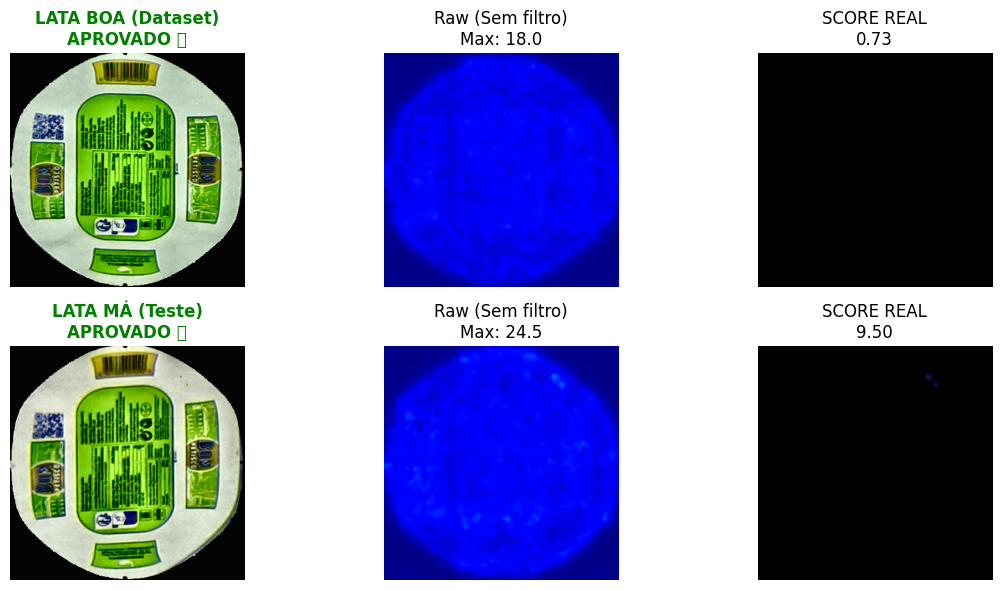


✅ Se a Lata Boa tiver Score < 5 e a Lata Má > 10, o modelo .xml está PERFEITO!


In [8]:
import openvino.runtime as ov
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

print("🛡️ A VALIDAR OS MODELOS EXPORTADOS (.XML)...")

# ==============================================================================
# 1. SIMULADOR DA CLASSE DO RASPBERRY PI
# (Esta é a cópia exata da lógica que definimos para o Pi)
# ==============================================================================
class PiSimulationInferencer:
    def __init__(self, model_dir="pi5_final_release"):
        self.core = ov.Core()

        # Carregar Modelo
        model_xml = os.path.join(model_dir, "model.xml")
        if not os.path.exists(model_xml):
            raise FileNotFoundError(f"Modelo XML não encontrado: {model_xml}")

        self.model = self.core.read_model(model_xml)
        self.compiled_model = self.core.compile_model(self.model, "CPU")
        self.infer_request = self.compiled_model.create_infer_request()

        # Carregar Mapa de Tolerância
        map_path = os.path.join(model_dir, "threshold_map.npy")
        if os.path.exists(map_path):
            self.threshold_map = np.load(map_path)
            print(f"   -> Threshold Map carregado. (Min: {self.threshold_map.min():.1f})")
        else:
            print("   ⚠️ AVISO: threshold_map.npy não encontrado. Usando fallback.")
            self.threshold_map = 15.0

        # Normalização ImageNet
        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        self.std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    def preprocess(self, image_path):
        # Ler imagem
        img = cv2.imread(image_path)
        if img is None: return None, None

        # --- LÓGICA CLAHE (Igual ao Pi) ---
        # Nota: Se as imagens do dataset JÁ tiverem CLAHE aplicado,
        # aplicar de novo pode ser excessivo, mas vamos testar a pipeline completa.
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        img_clahe = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        # ----------------------------------

        # Resize & Normalize
        resized = cv2.resize(img_clahe, (448, 448))
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

        norm = rgb.astype(np.float32) / 255.0
        norm = (norm - self.mean) / self.std

        # Transpose (H,W,C) -> (1,C,H,W)
        tensor = norm.transpose(2, 0, 1)[None, :, :, :]
        return tensor, resized

    def predict(self, image_path):
        input_tensor, display_img = self.preprocess(image_path)
        if input_tensor is None: return None

        # 1. Inferência OpenVINO
        results = self.infer_request.infer([input_tensor])
        raw_map = list(results.values())[0].squeeze()

        # 2. A Lógica Mágica (Raw - Threshold)
        clean_map = np.maximum(raw_map - self.threshold_map, 0)

        # 3. Score
        score = np.max(clean_map)

        return {
            "score": score,
            "raw": raw_map,
            "clean": clean_map,
            "img": display_img
        }

# ==============================================================================
# 2. EXECUTAR O TESTE
# ==============================================================================
try:
    # Instanciar o "Motor do Pi"
    pi_engine = PiSimulationInferencer("pi5_final_release")

    # Definir Imagens de Teste
    # 1. Imagem Má (Externa)
    path_bad = "/content/can001_def.png"

    # 2. Imagem Boa (Vamos buscar uma qualquer ao dataset de treino)
    # Ajuste o caminho se necessário, mas deve estar em dataset/train/good
    path_good = glob.glob("dataset/train/good/*.png")[234]

    imgs_to_test = [
        ("LATA BOA (Dataset)", path_good),
        ("LATA MÁ (Teste)", path_bad)
    ]

    plt.figure(figsize=(12, 6))

    for i, (titulo, path) in enumerate(imgs_to_test):
        res = pi_engine.predict(path)

        if res:
            # Lógica de decisão
            status = "REJEITADO ❌" if res['score'] > 10.0 else "APROVADO ✅"
            cor = 'red' if res['score'] > 10.0 else 'green'

            # 1. Imagem Original
            plt.subplot(2, 3, (i*3) + 1)
            plt.imshow(cv2.cvtColor(res['img'], cv2.COLOR_BGR2RGB))
            plt.title(f"{titulo}\n{status}", color=cor, fontweight='bold')
            plt.axis('off')

            # 2. Raw Map (O que o modelo vê)
            plt.subplot(2, 3, (i*3) + 2)
            plt.imshow(res['raw'], cmap='jet', vmin=0, vmax=100)
            plt.title(f"Raw (Sem filtro)\nMax: {res['raw'].max():.1f}")
            plt.axis('off')

            # 3. Clean Map (O Score Real)
            plt.subplot(2, 3, (i*3) + 3)
            plt.imshow(res['clean'], cmap='inferno', vmin=0, vmax=50)
            plt.title(f"SCORE REAL\n{res['score']:.2f}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    print("\n✅ Se a Lata Boa tiver Score < 5 e a Lata Má > 10, o modelo .xml está PERFEITO!")

except Exception as e:
    print(f"❌ Erro no teste: {e}")
    print("Verifica se a pasta 'pi5_final_release' existe e tem os ficheiros .xml e .npy")

6. Exportação Final (OpenVINO)
Se o teste visual acima funcionou (Boa=Aprovada, Má=Rejeitada), corre isto para baixar o ZIP.

In [7]:
# 1. INSTALAR O QUE FALTA (Sem reiniciar)
!pip install onnxscript onnx

import openvino as ov
import torch
import shutil
import os
import numpy as np
from google.colab import files

print("📦 A TENTAR EXPORTAR NOVAMENTE...")

# 2. CRIAR PASTA
output_folder = "pi5_final_release"
if os.path.exists(output_folder): shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)

# 3. EXPORTAR PARA ONNX
onnx_path = os.path.join(output_folder, "model.onnx")

print("   -> A converter PyTorch para ONNX...")
try:
    torch.onnx.export(
        sistema,
        torch.randn(1, 3, 448, 448).to(device),
        onnx_path,
        opset_version=14, # Trocamos para 14 que é mais compatível com onnxscript
        input_names=["input"],
        output_names=["output"]
    )
    print("   -> ONNX gerado com sucesso.")

    # 4. CONVERTER PARA OPENVINO
    print("   -> A converter para OpenVINO (FP16)...")
    ov_model = ov.convert_model(onnx_path)
    ov.save_model(ov_model, os.path.join(output_folder, "model.xml"), compress_to_fp16=True)

    # 5. GUARDAR MAPA
    print("   -> A guardar Mapa de Tolerância...")
    if 'threshold_map_final.npy' in os.listdir():
        shutil.copy("threshold_map_final.npy", os.path.join(output_folder, "threshold_map.npy"))
    else:
        np.save(os.path.join(output_folder, "threshold_map.npy"), threshold_map)

    # 6. ZIP E DOWNLOAD
    print("   -> A criar ZIP...")
    shutil.make_archive("SISTEMA_PI5_FINAL", 'zip', output_folder)

    print("\n🚀 SUCESSO! O download deve começar agora.")
    files.download("SISTEMA_PI5_FINAL.zip")

except Exception as e:
    print(f"\n❌ ERRO NA EXPORTAÇÃO: {e}")
    print("Se este erro persistir, infelizmente terás de reiniciar o runtime e instalar 'pip install onnxscript' logo no início.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 16.7 MB/s eta 0:00:00
📦 A TENTAR EXPORTAR NOVAMENTE...
   -> A converter PyTorch para ONNX...


W0126 11:56:43.324000 1515 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 14 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `PatchCoreEngine([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `PatchCoreEngine([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/BaseConverter.h:65: adapter_lookup: Assertion `false`

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 21 of general pattern rewrite rules.
   -> ONNX gerado com sucesso.
   -> A converter para OpenVINO (FP16)...
   -> A guardar Mapa de Tolerância...
   -> A criar ZIP...

🚀 SUCESSO! O download deve começar agora.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>